In [70]:

import os

%matplotlib inline
import sys
import rdkit
from rdkit import Chem
from rdkit.Chem import Crippen
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
import matplotlib.pyplot as plt
plt.ion()
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn import under_sampling, over_sampling

In [71]:
df_indexed=pd.read_csv('indexed_final_protacpedia.csv')
df=pd.read_csv('all_experimental_scores.csv')

In [72]:
df_indexed=df_indexed.drop(['identifier'], axis=1)
df_indexed = df_indexed.rename(columns={'pp_plus_linkers_amber_renumbered_mol': 'mol_refined','E3 Binder SMILES': 'e3_smiles', 'Ligand SMILES': 'poi_smiles', 'PROTAC SMILES': 'protac_smiles','new_name':'identifier', 'Active/Inactive':'flag'})
df_indexed=df_indexed.drop(['mol_refined','Copy of mol', 'PROTACDB ID', 'protac_smiles', 'Best PROTAC', 'Cells', 'cLogP', 'Comments', 'Curator', 'Dc50', 'Dmax', 'e3_smiles', 'E3 Ligase', 'Ec50 of Ligand Cells', 'Ec50 of PROTAC Cells', 'exit_vector', 'Hbond acceptors', 'Hbond donors', 'Ic50 of Ligand', 'Ic50 of PROTAC', 'Ligand Name', 'poi_smiles', 'Copy of Ligand SMILES', 'Linker', 'Copy of Linker', 'Linker Type', 'linker_ha', 'linker_no', 'linker_rb', 'MW', 'Off Targets Reported', 'PATENT', 'Ligand PDB', 'Ligand ID', 'Pubmed', 'PROTAC Name', 'Proteomics Data Available', 'Secondary Pubmed', 'Status', 'Target', 'Tested A Non Binding E3 Control', 'Tested Competition With Ligand', 'Tested Engagement In Cells', 'Tested Proteaseome Inhibitor', 'Time', 'TPSA', 'ligand_pdb_copy', 'ligand_pdb'], axis=1)
df_indexed=df_indexed[['identifier','mol','flag']]
df_indexed['flag'] = df_indexed['flag'].replace(['Inactive'],0)
df_indexed['flag'] = df_indexed['flag'].replace(['Active'],1)
df_indexed["identifier"] = df_indexed["identifier"].str.lower()

In [73]:
list(df.columns)
df=df.drop(['Unnamed: 0','Unnamed: 0.1','title.1','icm_poi_lig_score.1','icm_e3_lig_score.1','icm_e3_lig_score.1','title.2','icm_poi_lig_score.2','icm_e3_lig_score.2','icm_e3_lig_score.2','title.3','icm_poi_lig_score.3','icm_e3_lig_score.3','icm_e3_lig_score.3','title.4','icm_poi_lig_score.4','icm_e3_lig_score.4','icm_e3_lig_score.4','title.5','icm_poi_lig_score.5','icm_e3_lig_score.5','icm_e3_lig_score.5','title.6','icm_poi_lig_score.6','icm_e3_lig_score.6','icm_e3_lig_score.6','title.7','icm_poi_lig_score.7','icm_e3_lig_score.7','icm_e3_lig_score.7','title.8','icm_poi_lig_score.8','icm_e3_lig_score.8','icm_e3_lig_score.8','title.9','icm_poi_lig_score.9','icm_e3_lig_score.9','icm_e3_lig_score.9','title.10','icm_poi_lig_score.10','icm_e3_lig_score.10','icm_e3_lig_score.10','title.11','icm_poi_lig_score.11','icm_e3_lig_score.11','icm_e3_lig_score.11','title.12','icm_poi_lig_score.12','icm_e3_lig_score.12','icm_e3_lig_score.12','title.13','icm_poi_lig_score.13','icm_e3_lig_score.13','icm_e3_lig_score.13','title.14','icm_poi_lig_score.14','icm_e3_lig_score.14','icm_e3_lig_score.14','title.15','icm_poi_lig_score.15','icm_e3_lig_score.15','icm_e3_lig_score.15','title.16','icm_poi_lig_score.16','icm_e3_lig_score.16','icm_e3_lig_score.16','title.17','icm_poi_lig_score.17','icm_e3_lig_score.17','icm_e3_lig_score.17','title.18','icm_poi_lig_score.18','icm_e3_lig_score.18','icm_e3_lig_score.18','title.19','icm_poi_lig_score.19','icm_e3_lig_score.19','icm_e3_lig_score.19','rmsd_linker.1','rmsd_linker.2','rmsd_linker.3','rmsd_linker.4','rmsd_linker.5','rmsd_linker.6','rmsd_linker.7','rmsd_linker.8','rmsd_linker.9','rmsd_linker.10','rmsd_linker.11','rmsd_linker.12','rmsd_linker.13','rmsd_linker.14','rmsd_linker.15','rmsd_linker.16','rmsd_linker.17','rmsd_linker.18','rmsd_linker.19'], axis=1)

In [74]:
df['title']=df['title'].apply(lambda x: ("_").join(str(x).split('_')[0:2]))

In [75]:
df_merged=pd.merge(df,df_indexed,how="left",left_on=["title"], right_on=["identifier"])

In [76]:
df_merged=df_merged.drop(['identifier'],axis=1)

In [77]:
df_merged.columns = df_merged.columns.str.replace("[.]", "_")

In [78]:
df_merged['mol_rdkit']=df_merged['mol'].apply(Chem.MolFromSmiles)

In [79]:
df_merged['Hacc_protac'] = df_merged['mol_rdkit'].apply(Chem.rdMolDescriptors.CalcNumHBA)
df_merged['Hdon_protac'] = df_merged['mol_rdkit'].apply(Chem.rdMolDescriptors.CalcNumHBD)
df_merged['TPSA_protac'] = df_merged['mol_rdkit'].apply(Chem.rdMolDescriptors.CalcTPSA)
df_merged['cLogP_protac'] = df_merged['mol_rdkit'].apply(Crippen.MolLogP)
df_merged['MW_protac'] = df_merged['mol_rdkit'].apply(Chem.rdMolDescriptors.CalcExactMolWt)
df_merged['FSP3'] = df_merged['mol_rdkit'].apply(Chem.rdMolDescriptors.CalcFractionCSP3)

In [80]:
df_merged=df_merged.drop(['mol_rdkit','mol','title'],axis=1)

In [81]:
df_merged=df_merged.fillna(0)

In [82]:

for idx,feat in enumerate(list(df_merged.columns)[1:97]):
    df_merged[f'{feat}_avg']=df_merged[list(df_merged.filter(regex=feat))].mean(axis=1)

In [83]:
for idx,feat in enumerate(list(df_merged.columns)[1:97]):
    df_merged[f'{feat}_sum']=df_merged[list(df_merged.filter(regex=feat))].sum(axis=1)

In [84]:
df_merged=df_merged.fillna(0)

In [85]:
X_train,X_test, y_train,y_test = train_test_split(df_merged, df_merged['flag'], test_size=0.20, random_state=1,stratify=df_merged['flag'])

In [86]:
X_train.drop("flag",axis=1,inplace=True)
X_test.drop("flag",axis=1,inplace=True)

/home/hmslati/.local/lib/python3.6/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
from sklearn.preprocessing import RobustScaler
preprocessor = make_pipeline(RobustScaler())

In [49]:
transformed = preprocessor.fit_transform(X_train)

In [88]:

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [89]:
results = {}
scoring_metric = "accuracy"

dummy = DummyClassifier(strategy="stratified")
pipe_dt = make_pipeline(preprocessor, dummy)

results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T



,fit_time,score_time,test_score,train_score
Dummy,0.009 (+/- 0.001),0.001 (+/- 0.000),0.539 (+/- 0.041),0.564 (+/- 0.019)
Decision tree,1.844 (+/- 0.492),0.020 (+/- 0.000),0.629 (+/- 0.010),1.000 (+/- 0.000)


In [90]:
logistic = LogisticRegression()

pipe_lr = make_pipeline(
    preprocessor, logistic
)
results["logisitic_regresion"]=mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

/home/hmslati/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/hmslati/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

,fit_time,score_time,test_score,train_score
Dummy,0.009 (+/- 0.001),0.001 (+/- 0.000),0.539 (+/- 0.041),0.564 (+/- 0.019)
Decision tree,1.844 (+/- 0.492),0.020 (+/- 0.000),0.629 (+/- 0.010),1.000 (+/- 0.000)
logisitic_regresion,0.639 (+/- 0.026),0.037 (+/- 0.008),0.649 (+/- 0.046),0.668 (+/- 0.006)


In [701]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(random_state=123)
)
classifiers = {
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}


for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

Learning rate set to 0.009235
0:	learn: 0.6910473	total: 303ms	remaining: 5m 2s
1:	learn: 0.6886517	total: 536ms	remaining: 4m 27s
2:	learn: 0.6866451	total: 777ms	remaining: 4m 18s
3:	learn: 0.6845575	total: 1.02s	remaining: 4m 13s
4:	learn: 0.6823401	total: 1.27s	remaining: 4m 13s
5:	learn: 0.6799473	total: 1.51s	remaining: 4m 10s
6:	learn: 0.6777483	total: 1.75s	remaining: 4m 7s
7:	learn: 0.6760514	total: 1.98s	remaining: 4m 5s
8:	learn: 0.6738360	total: 2.21s	remaining: 4m 3s
9:	learn: 0.6720565	total: 2.47s	remaining: 4m 4s
10:	learn: 0.6699522	total: 2.71s	remaining: 4m 3s
11:	learn: 0.6680661	total: 2.95s	remaining: 4m 2s
12:	learn: 0.6664585	total: 3.21s	remaining: 4m 4s
13:	learn: 0.6643923	total: 3.45s	remaining: 4m 3s
14:	learn: 0.6620449	total: 3.69s	remaining: 4m 2s
15:	learn: 0.6598716	total: 3.92s	remaining: 4m
16:	learn: 0.6576515	total: 4.16s	remaining: 4m
17:	learn: 0.6555917	total: 4.39s	remaining: 3m 59s
18:	learn: 0.6536822	total: 4.63s	remaining: 3m 59s
19:	learn:

157:	learn: 0.4892364	total: 37.5s	remaining: 3m 19s
158:	learn: 0.4885071	total: 37.7s	remaining: 3m 19s
159:	learn: 0.4876513	total: 37.9s	remaining: 3m 19s
160:	learn: 0.4869988	total: 38.2s	remaining: 3m 18s
161:	learn: 0.4860947	total: 38.4s	remaining: 3m 18s
162:	learn: 0.4854228	total: 38.6s	remaining: 3m 18s
163:	learn: 0.4842953	total: 38.9s	remaining: 3m 18s
164:	learn: 0.4835260	total: 39.1s	remaining: 3m 17s
165:	learn: 0.4829022	total: 39.3s	remaining: 3m 17s
166:	learn: 0.4821756	total: 39.6s	remaining: 3m 17s
167:	learn: 0.4812302	total: 39.8s	remaining: 3m 17s
168:	learn: 0.4804343	total: 40s	remaining: 3m 16s
169:	learn: 0.4797649	total: 40.3s	remaining: 3m 16s
170:	learn: 0.4790748	total: 40.5s	remaining: 3m 16s
171:	learn: 0.4781405	total: 40.7s	remaining: 3m 16s
172:	learn: 0.4776927	total: 41s	remaining: 3m 15s
173:	learn: 0.4763998	total: 41.2s	remaining: 3m 15s
174:	learn: 0.4756949	total: 41.4s	remaining: 3m 15s
175:	learn: 0.4749631	total: 41.7s	remaining: 3m 1

313:	learn: 0.3869901	total: 1m 15s	remaining: 2m 43s
314:	learn: 0.3863844	total: 1m 15s	remaining: 2m 43s
315:	learn: 0.3858662	total: 1m 15s	remaining: 2m 43s
316:	learn: 0.3852813	total: 1m 15s	remaining: 2m 43s
317:	learn: 0.3844129	total: 1m 16s	remaining: 2m 43s
318:	learn: 0.3835883	total: 1m 16s	remaining: 2m 43s
319:	learn: 0.3828796	total: 1m 16s	remaining: 2m 42s
320:	learn: 0.3824223	total: 1m 16s	remaining: 2m 42s
321:	learn: 0.3816766	total: 1m 17s	remaining: 2m 42s
322:	learn: 0.3811633	total: 1m 17s	remaining: 2m 42s
323:	learn: 0.3803088	total: 1m 17s	remaining: 2m 41s
324:	learn: 0.3799191	total: 1m 17s	remaining: 2m 41s
325:	learn: 0.3794591	total: 1m 18s	remaining: 2m 41s
326:	learn: 0.3791044	total: 1m 18s	remaining: 2m 41s
327:	learn: 0.3785069	total: 1m 18s	remaining: 2m 40s
328:	learn: 0.3780075	total: 1m 18s	remaining: 2m 40s
329:	learn: 0.3771205	total: 1m 19s	remaining: 2m 40s
330:	learn: 0.3765569	total: 1m 19s	remaining: 2m 40s
331:	learn: 0.3761666	total:

465:	learn: 0.3152079	total: 1m 52s	remaining: 2m 8s
466:	learn: 0.3148030	total: 1m 52s	remaining: 2m 8s
467:	learn: 0.3144188	total: 1m 52s	remaining: 2m 8s
468:	learn: 0.3140064	total: 1m 52s	remaining: 2m 7s
469:	learn: 0.3135078	total: 1m 53s	remaining: 2m 7s
470:	learn: 0.3132058	total: 1m 53s	remaining: 2m 7s
471:	learn: 0.3127655	total: 1m 53s	remaining: 2m 7s
472:	learn: 0.3125623	total: 1m 53s	remaining: 2m 6s
473:	learn: 0.3120911	total: 1m 54s	remaining: 2m 6s
474:	learn: 0.3116056	total: 1m 54s	remaining: 2m 6s
475:	learn: 0.3111310	total: 1m 54s	remaining: 2m 6s
476:	learn: 0.3107278	total: 1m 54s	remaining: 2m 5s
477:	learn: 0.3103350	total: 1m 55s	remaining: 2m 5s
478:	learn: 0.3099814	total: 1m 55s	remaining: 2m 5s
479:	learn: 0.3095069	total: 1m 55s	remaining: 2m 5s
480:	learn: 0.3090749	total: 1m 55s	remaining: 2m 5s
481:	learn: 0.3086306	total: 1m 56s	remaining: 2m 4s
482:	learn: 0.3081515	total: 1m 56s	remaining: 2m 4s
483:	learn: 0.3078328	total: 1m 56s	remaining:

619:	learn: 0.2563544	total: 2m 29s	remaining: 1m 31s
620:	learn: 0.2561019	total: 2m 29s	remaining: 1m 31s
621:	learn: 0.2558400	total: 2m 30s	remaining: 1m 31s
622:	learn: 0.2554160	total: 2m 30s	remaining: 1m 30s
623:	learn: 0.2550752	total: 2m 30s	remaining: 1m 30s
624:	learn: 0.2546887	total: 2m 30s	remaining: 1m 30s
625:	learn: 0.2543057	total: 2m 30s	remaining: 1m 30s
626:	learn: 0.2539763	total: 2m 31s	remaining: 1m 29s
627:	learn: 0.2536915	total: 2m 31s	remaining: 1m 29s
628:	learn: 0.2535262	total: 2m 31s	remaining: 1m 29s
629:	learn: 0.2531346	total: 2m 31s	remaining: 1m 29s
630:	learn: 0.2527629	total: 2m 32s	remaining: 1m 28s
631:	learn: 0.2522334	total: 2m 32s	remaining: 1m 28s
632:	learn: 0.2518958	total: 2m 32s	remaining: 1m 28s
633:	learn: 0.2513184	total: 2m 32s	remaining: 1m 28s
634:	learn: 0.2511090	total: 2m 33s	remaining: 1m 28s
635:	learn: 0.2505660	total: 2m 33s	remaining: 1m 27s
636:	learn: 0.2503284	total: 2m 33s	remaining: 1m 27s
637:	learn: 0.2499719	total:

773:	learn: 0.2042019	total: 3m 6s	remaining: 54.6s
774:	learn: 0.2038365	total: 3m 7s	remaining: 54.3s
775:	learn: 0.2034865	total: 3m 7s	remaining: 54.1s
776:	learn: 0.2030717	total: 3m 7s	remaining: 53.9s
777:	learn: 0.2026064	total: 3m 7s	remaining: 53.6s
778:	learn: 0.2021872	total: 3m 8s	remaining: 53.4s
779:	learn: 0.2016606	total: 3m 8s	remaining: 53.1s
780:	learn: 0.2014062	total: 3m 8s	remaining: 52.9s
781:	learn: 0.2010302	total: 3m 8s	remaining: 52.7s
782:	learn: 0.2006338	total: 3m 9s	remaining: 52.4s
783:	learn: 0.2000798	total: 3m 9s	remaining: 52.2s
784:	learn: 0.1997328	total: 3m 9s	remaining: 52s
785:	learn: 0.1993627	total: 3m 10s	remaining: 51.7s
786:	learn: 0.1991280	total: 3m 10s	remaining: 51.5s
787:	learn: 0.1987765	total: 3m 10s	remaining: 51.3s
788:	learn: 0.1984729	total: 3m 10s	remaining: 51s
789:	learn: 0.1982878	total: 3m 11s	remaining: 50.8s
790:	learn: 0.1978699	total: 3m 11s	remaining: 50.6s
791:	learn: 0.1975033	total: 3m 11s	remaining: 50.3s
792:	lear

929:	learn: 0.1555577	total: 3m 45s	remaining: 17s
930:	learn: 0.1553313	total: 3m 45s	remaining: 16.7s
931:	learn: 0.1550941	total: 3m 45s	remaining: 16.5s
932:	learn: 0.1547929	total: 3m 46s	remaining: 16.2s
933:	learn: 0.1545089	total: 3m 46s	remaining: 16s
934:	learn: 0.1543073	total: 3m 46s	remaining: 15.8s
935:	learn: 0.1540033	total: 3m 46s	remaining: 15.5s
936:	learn: 0.1536579	total: 3m 47s	remaining: 15.3s
937:	learn: 0.1533842	total: 3m 47s	remaining: 15s
938:	learn: 0.1530692	total: 3m 47s	remaining: 14.8s
939:	learn: 0.1528212	total: 3m 47s	remaining: 14.5s
940:	learn: 0.1525158	total: 3m 48s	remaining: 14.3s
941:	learn: 0.1522683	total: 3m 48s	remaining: 14.1s
942:	learn: 0.1519729	total: 3m 48s	remaining: 13.8s
943:	learn: 0.1517984	total: 3m 48s	remaining: 13.6s
944:	learn: 0.1514899	total: 3m 49s	remaining: 13.3s
945:	learn: 0.1512470	total: 3m 49s	remaining: 13.1s
946:	learn: 0.1509358	total: 3m 49s	remaining: 12.9s
947:	learn: 0.1506661	total: 3m 49s	remaining: 12.6s

87:	learn: 0.5556408	total: 21.3s	remaining: 3m 41s
88:	learn: 0.5545139	total: 21.6s	remaining: 3m 41s
89:	learn: 0.5537986	total: 21.8s	remaining: 3m 40s
90:	learn: 0.5524564	total: 22.1s	remaining: 3m 40s
91:	learn: 0.5511147	total: 22.3s	remaining: 3m 40s
92:	learn: 0.5505669	total: 22.6s	remaining: 3m 40s
93:	learn: 0.5491192	total: 22.8s	remaining: 3m 39s
94:	learn: 0.5478924	total: 23s	remaining: 3m 39s
95:	learn: 0.5468916	total: 23.3s	remaining: 3m 39s
96:	learn: 0.5459280	total: 23.6s	remaining: 3m 39s
97:	learn: 0.5448444	total: 23.8s	remaining: 3m 38s
98:	learn: 0.5440069	total: 24s	remaining: 3m 38s
99:	learn: 0.5431962	total: 24.3s	remaining: 3m 38s
100:	learn: 0.5422491	total: 24.5s	remaining: 3m 38s
101:	learn: 0.5414629	total: 24.8s	remaining: 3m 38s
102:	learn: 0.5404965	total: 25s	remaining: 3m 37s
103:	learn: 0.5397046	total: 25.3s	remaining: 3m 37s
104:	learn: 0.5387104	total: 25.5s	remaining: 3m 37s
105:	learn: 0.5380541	total: 25.7s	remaining: 3m 37s
106:	learn: 

244:	learn: 0.4303209	total: 59.7s	remaining: 3m 4s
245:	learn: 0.4297140	total: 60s	remaining: 3m 3s
246:	learn: 0.4289385	total: 1m	remaining: 3m 3s
247:	learn: 0.4284907	total: 1m	remaining: 3m 3s
248:	learn: 0.4278357	total: 1m	remaining: 3m 2s
249:	learn: 0.4272668	total: 1m	remaining: 3m 2s
250:	learn: 0.4266576	total: 1m 1s	remaining: 3m 2s
251:	learn: 0.4260714	total: 1m 1s	remaining: 3m 2s
252:	learn: 0.4255657	total: 1m 1s	remaining: 3m 1s
253:	learn: 0.4246694	total: 1m 1s	remaining: 3m 1s
254:	learn: 0.4243240	total: 1m 2s	remaining: 3m 1s
255:	learn: 0.4236516	total: 1m 2s	remaining: 3m 1s
256:	learn: 0.4229369	total: 1m 2s	remaining: 3m
257:	learn: 0.4224046	total: 1m 2s	remaining: 3m
258:	learn: 0.4213878	total: 1m 3s	remaining: 3m
259:	learn: 0.4207887	total: 1m 3s	remaining: 3m
260:	learn: 0.4201809	total: 1m 3s	remaining: 2m 59s
261:	learn: 0.4194746	total: 1m 3s	remaining: 2m 59s
262:	learn: 0.4188124	total: 1m 3s	remaining: 2m 59s
263:	learn: 0.4181663	total: 1m 4s	

398:	learn: 0.3479567	total: 1m 37s	remaining: 2m 26s
399:	learn: 0.3472873	total: 1m 37s	remaining: 2m 25s
400:	learn: 0.3468353	total: 1m 37s	remaining: 2m 25s
401:	learn: 0.3463172	total: 1m 37s	remaining: 2m 25s
402:	learn: 0.3461211	total: 1m 38s	remaining: 2m 25s
403:	learn: 0.3456626	total: 1m 38s	remaining: 2m 25s
404:	learn: 0.3451881	total: 1m 38s	remaining: 2m 24s
405:	learn: 0.3448073	total: 1m 38s	remaining: 2m 24s
406:	learn: 0.3442233	total: 1m 39s	remaining: 2m 24s
407:	learn: 0.3435294	total: 1m 39s	remaining: 2m 24s
408:	learn: 0.3429949	total: 1m 39s	remaining: 2m 23s
409:	learn: 0.3422940	total: 1m 39s	remaining: 2m 23s
410:	learn: 0.3420783	total: 1m 40s	remaining: 2m 23s
411:	learn: 0.3415516	total: 1m 40s	remaining: 2m 23s
412:	learn: 0.3412061	total: 1m 40s	remaining: 2m 22s
413:	learn: 0.3409489	total: 1m 40s	remaining: 2m 22s
414:	learn: 0.3406911	total: 1m 40s	remaining: 2m 22s
415:	learn: 0.3401670	total: 1m 41s	remaining: 2m 22s
416:	learn: 0.3397655	total:

552:	learn: 0.2845708	total: 2m 15s	remaining: 1m 49s
553:	learn: 0.2841559	total: 2m 15s	remaining: 1m 49s
554:	learn: 0.2838703	total: 2m 15s	remaining: 1m 49s
555:	learn: 0.2835123	total: 2m 16s	remaining: 1m 48s
556:	learn: 0.2830922	total: 2m 16s	remaining: 1m 48s
557:	learn: 0.2826814	total: 2m 16s	remaining: 1m 48s
558:	learn: 0.2824322	total: 2m 16s	remaining: 1m 48s
559:	learn: 0.2819832	total: 2m 17s	remaining: 1m 47s
560:	learn: 0.2816016	total: 2m 17s	remaining: 1m 47s
561:	learn: 0.2813037	total: 2m 17s	remaining: 1m 47s
562:	learn: 0.2809924	total: 2m 17s	remaining: 1m 47s
563:	learn: 0.2807175	total: 2m 18s	remaining: 1m 46s
564:	learn: 0.2803808	total: 2m 18s	remaining: 1m 46s
565:	learn: 0.2800427	total: 2m 18s	remaining: 1m 46s
566:	learn: 0.2795788	total: 2m 18s	remaining: 1m 46s
567:	learn: 0.2790885	total: 2m 19s	remaining: 1m 45s
568:	learn: 0.2785644	total: 2m 19s	remaining: 1m 45s
569:	learn: 0.2782118	total: 2m 19s	remaining: 1m 45s
570:	learn: 0.2778575	total:

704:	learn: 0.2322665	total: 2m 51s	remaining: 1m 11s
705:	learn: 0.2319877	total: 2m 51s	remaining: 1m 11s
706:	learn: 0.2316543	total: 2m 51s	remaining: 1m 11s
707:	learn: 0.2312565	total: 2m 52s	remaining: 1m 11s
708:	learn: 0.2309190	total: 2m 52s	remaining: 1m 10s
709:	learn: 0.2305986	total: 2m 52s	remaining: 1m 10s
710:	learn: 0.2303221	total: 2m 52s	remaining: 1m 10s
711:	learn: 0.2299530	total: 2m 53s	remaining: 1m 10s
712:	learn: 0.2294306	total: 2m 53s	remaining: 1m 9s
713:	learn: 0.2290913	total: 2m 53s	remaining: 1m 9s
714:	learn: 0.2288352	total: 2m 53s	remaining: 1m 9s
715:	learn: 0.2285568	total: 2m 54s	remaining: 1m 9s
716:	learn: 0.2282051	total: 2m 54s	remaining: 1m 8s
717:	learn: 0.2279144	total: 2m 54s	remaining: 1m 8s
718:	learn: 0.2273983	total: 2m 54s	remaining: 1m 8s
719:	learn: 0.2270338	total: 2m 54s	remaining: 1m 8s
720:	learn: 0.2267559	total: 2m 55s	remaining: 1m 7s
721:	learn: 0.2264944	total: 2m 55s	remaining: 1m 7s
722:	learn: 0.2261636	total: 2m 55s	re

861:	learn: 0.1807591	total: 3m 29s	remaining: 33.6s
862:	learn: 0.1805065	total: 3m 30s	remaining: 33.3s
863:	learn: 0.1802196	total: 3m 30s	remaining: 33.1s
864:	learn: 0.1797408	total: 3m 30s	remaining: 32.9s
865:	learn: 0.1794544	total: 3m 30s	remaining: 32.6s
866:	learn: 0.1790863	total: 3m 31s	remaining: 32.4s
867:	learn: 0.1787992	total: 3m 31s	remaining: 32.1s
868:	learn: 0.1784074	total: 3m 31s	remaining: 31.9s
869:	learn: 0.1780122	total: 3m 31s	remaining: 31.6s
870:	learn: 0.1777467	total: 3m 31s	remaining: 31.4s
871:	learn: 0.1774831	total: 3m 32s	remaining: 31.1s
872:	learn: 0.1771520	total: 3m 32s	remaining: 30.9s
873:	learn: 0.1768303	total: 3m 32s	remaining: 30.7s
874:	learn: 0.1765437	total: 3m 32s	remaining: 30.4s
875:	learn: 0.1763608	total: 3m 33s	remaining: 30.2s
876:	learn: 0.1760879	total: 3m 33s	remaining: 29.9s
877:	learn: 0.1757407	total: 3m 33s	remaining: 29.7s
878:	learn: 0.1755568	total: 3m 33s	remaining: 29.4s
879:	learn: 0.1751791	total: 3m 34s	remaining:

17:	learn: 0.6540294	total: 4.55s	remaining: 4m 8s
18:	learn: 0.6514674	total: 4.8s	remaining: 4m 7s
19:	learn: 0.6496223	total: 5.03s	remaining: 4m 6s
20:	learn: 0.6482471	total: 5.27s	remaining: 4m 5s
21:	learn: 0.6462567	total: 5.51s	remaining: 4m 5s
22:	learn: 0.6444578	total: 5.75s	remaining: 4m 4s
23:	learn: 0.6424590	total: 5.99s	remaining: 4m 3s
24:	learn: 0.6407439	total: 6.23s	remaining: 4m 2s
25:	learn: 0.6384417	total: 6.46s	remaining: 4m 1s
26:	learn: 0.6367338	total: 6.69s	remaining: 4m 1s
27:	learn: 0.6354036	total: 6.92s	remaining: 4m
28:	learn: 0.6336363	total: 7.17s	remaining: 3m 59s
29:	learn: 0.6320580	total: 7.41s	remaining: 3m 59s
30:	learn: 0.6305944	total: 7.64s	remaining: 3m 58s
31:	learn: 0.6291283	total: 7.88s	remaining: 3m 58s
32:	learn: 0.6274376	total: 8.12s	remaining: 3m 57s
33:	learn: 0.6255025	total: 8.37s	remaining: 3m 57s
34:	learn: 0.6236030	total: 8.61s	remaining: 3m 57s
35:	learn: 0.6219513	total: 8.85s	remaining: 3m 56s
36:	learn: 0.6203005	total:

174:	learn: 0.4743197	total: 41.9s	remaining: 3m 17s
175:	learn: 0.4737136	total: 42.2s	remaining: 3m 17s
176:	learn: 0.4730964	total: 42.4s	remaining: 3m 17s
177:	learn: 0.4723361	total: 42.7s	remaining: 3m 17s
178:	learn: 0.4716606	total: 42.9s	remaining: 3m 16s
179:	learn: 0.4712178	total: 43.1s	remaining: 3m 16s
180:	learn: 0.4703167	total: 43.4s	remaining: 3m 16s
181:	learn: 0.4697404	total: 43.6s	remaining: 3m 16s
182:	learn: 0.4690302	total: 43.9s	remaining: 3m 15s
183:	learn: 0.4682928	total: 44.1s	remaining: 3m 15s
184:	learn: 0.4676620	total: 44.3s	remaining: 3m 15s
185:	learn: 0.4668727	total: 44.6s	remaining: 3m 15s
186:	learn: 0.4661395	total: 44.8s	remaining: 3m 14s
187:	learn: 0.4653989	total: 45s	remaining: 3m 14s
188:	learn: 0.4648673	total: 45.3s	remaining: 3m 14s
189:	learn: 0.4641684	total: 45.5s	remaining: 3m 13s
190:	learn: 0.4635554	total: 45.7s	remaining: 3m 13s
191:	learn: 0.4627305	total: 46s	remaining: 3m 13s
192:	learn: 0.4619222	total: 46.2s	remaining: 3m 1

330:	learn: 0.3796140	total: 1m 19s	remaining: 2m 40s
331:	learn: 0.3790918	total: 1m 19s	remaining: 2m 40s
332:	learn: 0.3785851	total: 1m 19s	remaining: 2m 39s
333:	learn: 0.3781489	total: 1m 20s	remaining: 2m 39s
334:	learn: 0.3776436	total: 1m 20s	remaining: 2m 39s
335:	learn: 0.3772385	total: 1m 20s	remaining: 2m 39s
336:	learn: 0.3767911	total: 1m 20s	remaining: 2m 38s
337:	learn: 0.3763782	total: 1m 21s	remaining: 2m 38s
338:	learn: 0.3757154	total: 1m 21s	remaining: 2m 38s
339:	learn: 0.3751293	total: 1m 21s	remaining: 2m 38s
340:	learn: 0.3748341	total: 1m 21s	remaining: 2m 37s
341:	learn: 0.3743747	total: 1m 21s	remaining: 2m 37s
342:	learn: 0.3739415	total: 1m 22s	remaining: 2m 37s
343:	learn: 0.3735982	total: 1m 22s	remaining: 2m 37s
344:	learn: 0.3731645	total: 1m 22s	remaining: 2m 36s
345:	learn: 0.3725493	total: 1m 22s	remaining: 2m 36s
346:	learn: 0.3719141	total: 1m 23s	remaining: 2m 36s
347:	learn: 0.3712566	total: 1m 23s	remaining: 2m 36s
348:	learn: 0.3708316	total:

483:	learn: 0.3092727	total: 1m 56s	remaining: 2m 4s
484:	learn: 0.3089913	total: 1m 56s	remaining: 2m 3s
485:	learn: 0.3085298	total: 1m 56s	remaining: 2m 3s
486:	learn: 0.3083017	total: 1m 57s	remaining: 2m 3s
487:	learn: 0.3080443	total: 1m 57s	remaining: 2m 3s
488:	learn: 0.3076445	total: 1m 57s	remaining: 2m 2s
489:	learn: 0.3074097	total: 1m 57s	remaining: 2m 2s
490:	learn: 0.3071448	total: 1m 58s	remaining: 2m 2s
491:	learn: 0.3068868	total: 1m 58s	remaining: 2m 2s
492:	learn: 0.3065192	total: 1m 58s	remaining: 2m 1s
493:	learn: 0.3060953	total: 1m 58s	remaining: 2m 1s
494:	learn: 0.3057320	total: 1m 59s	remaining: 2m 1s
495:	learn: 0.3052392	total: 1m 59s	remaining: 2m 1s
496:	learn: 0.3048618	total: 1m 59s	remaining: 2m 1s
497:	learn: 0.3044049	total: 1m 59s	remaining: 2m
498:	learn: 0.3038000	total: 2m	remaining: 2m
499:	learn: 0.3033212	total: 2m	remaining: 2m
500:	learn: 0.3027744	total: 2m	remaining: 2m
501:	learn: 0.3023427	total: 2m	remaining: 2m
502:	learn: 0.3020023	to

637:	learn: 0.2525218	total: 2m 34s	remaining: 1m 27s
638:	learn: 0.2522286	total: 2m 34s	remaining: 1m 27s
639:	learn: 0.2518850	total: 2m 34s	remaining: 1m 27s
640:	learn: 0.2514949	total: 2m 35s	remaining: 1m 26s
641:	learn: 0.2510559	total: 2m 35s	remaining: 1m 26s
642:	learn: 0.2508777	total: 2m 35s	remaining: 1m 26s
643:	learn: 0.2506781	total: 2m 35s	remaining: 1m 26s
644:	learn: 0.2502195	total: 2m 35s	remaining: 1m 25s
645:	learn: 0.2498933	total: 2m 36s	remaining: 1m 25s
646:	learn: 0.2495957	total: 2m 36s	remaining: 1m 25s
647:	learn: 0.2491913	total: 2m 36s	remaining: 1m 25s
648:	learn: 0.2488047	total: 2m 36s	remaining: 1m 24s
649:	learn: 0.2485632	total: 2m 37s	remaining: 1m 24s
650:	learn: 0.2481240	total: 2m 37s	remaining: 1m 24s
651:	learn: 0.2478098	total: 2m 37s	remaining: 1m 24s
652:	learn: 0.2474695	total: 2m 37s	remaining: 1m 23s
653:	learn: 0.2471042	total: 2m 38s	remaining: 1m 23s
654:	learn: 0.2467552	total: 2m 38s	remaining: 1m 23s
655:	learn: 0.2465865	total:

792:	learn: 0.2024035	total: 3m 11s	remaining: 50.1s
793:	learn: 0.2021376	total: 3m 12s	remaining: 49.8s
794:	learn: 0.2019073	total: 3m 12s	remaining: 49.6s
795:	learn: 0.2017160	total: 3m 12s	remaining: 49.3s
796:	learn: 0.2014834	total: 3m 12s	remaining: 49.1s
797:	learn: 0.2013373	total: 3m 13s	remaining: 48.9s
798:	learn: 0.2011398	total: 3m 13s	remaining: 48.6s
799:	learn: 0.2007384	total: 3m 13s	remaining: 48.4s
800:	learn: 0.2002948	total: 3m 13s	remaining: 48.1s
801:	learn: 0.1999492	total: 3m 13s	remaining: 47.9s
802:	learn: 0.1997324	total: 3m 14s	remaining: 47.6s
803:	learn: 0.1994317	total: 3m 14s	remaining: 47.4s
804:	learn: 0.1990687	total: 3m 14s	remaining: 47.2s
805:	learn: 0.1986985	total: 3m 14s	remaining: 46.9s
806:	learn: 0.1984032	total: 3m 15s	remaining: 46.7s
807:	learn: 0.1979938	total: 3m 15s	remaining: 46.4s
808:	learn: 0.1976277	total: 3m 15s	remaining: 46.2s
809:	learn: 0.1972220	total: 3m 15s	remaining: 45.9s
810:	learn: 0.1970271	total: 3m 16s	remaining:

948:	learn: 0.1578591	total: 3m 49s	remaining: 12.3s
949:	learn: 0.1575733	total: 3m 49s	remaining: 12.1s
950:	learn: 0.1571670	total: 3m 49s	remaining: 11.8s
951:	learn: 0.1567632	total: 3m 50s	remaining: 11.6s
952:	learn: 0.1566063	total: 3m 50s	remaining: 11.4s
953:	learn: 0.1563679	total: 3m 50s	remaining: 11.1s
954:	learn: 0.1561080	total: 3m 50s	remaining: 10.9s
955:	learn: 0.1559087	total: 3m 51s	remaining: 10.6s
956:	learn: 0.1556285	total: 3m 51s	remaining: 10.4s
957:	learn: 0.1553947	total: 3m 51s	remaining: 10.2s
958:	learn: 0.1552661	total: 3m 51s	remaining: 9.91s
959:	learn: 0.1551085	total: 3m 52s	remaining: 9.67s
960:	learn: 0.1548371	total: 3m 52s	remaining: 9.43s
961:	learn: 0.1545327	total: 3m 52s	remaining: 9.19s
962:	learn: 0.1543152	total: 3m 52s	remaining: 8.94s
963:	learn: 0.1539849	total: 3m 53s	remaining: 8.7s
964:	learn: 0.1537431	total: 3m 53s	remaining: 8.46s
965:	learn: 0.1534481	total: 3m 53s	remaining: 8.22s
966:	learn: 0.1532285	total: 3m 53s	remaining: 

106:	learn: 0.5396116	total: 25.4s	remaining: 3m 32s
107:	learn: 0.5380214	total: 25.7s	remaining: 3m 32s
108:	learn: 0.5371036	total: 25.9s	remaining: 3m 31s
109:	learn: 0.5362940	total: 26.2s	remaining: 3m 31s
110:	learn: 0.5355209	total: 26.4s	remaining: 3m 31s
111:	learn: 0.5344699	total: 26.6s	remaining: 3m 31s
112:	learn: 0.5334404	total: 26.9s	remaining: 3m 31s
113:	learn: 0.5322655	total: 27.1s	remaining: 3m 30s
114:	learn: 0.5312896	total: 27.4s	remaining: 3m 30s
115:	learn: 0.5303258	total: 27.6s	remaining: 3m 30s
116:	learn: 0.5288307	total: 27.9s	remaining: 3m 30s
117:	learn: 0.5278739	total: 28.1s	remaining: 3m 30s
118:	learn: 0.5273122	total: 28.4s	remaining: 3m 29s
119:	learn: 0.5266501	total: 28.6s	remaining: 3m 29s
120:	learn: 0.5253278	total: 28.9s	remaining: 3m 29s
121:	learn: 0.5242548	total: 29.1s	remaining: 3m 29s
122:	learn: 0.5233916	total: 29.3s	remaining: 3m 29s
123:	learn: 0.5223883	total: 29.6s	remaining: 3m 28s
124:	learn: 0.5215489	total: 29.8s	remaining: 

262:	learn: 0.4228349	total: 1m 5s	remaining: 3m 3s
263:	learn: 0.4224689	total: 1m 5s	remaining: 3m 3s
264:	learn: 0.4218863	total: 1m 6s	remaining: 3m 3s
265:	learn: 0.4212015	total: 1m 6s	remaining: 3m 2s
266:	learn: 0.4206142	total: 1m 6s	remaining: 3m 2s
267:	learn: 0.4199256	total: 1m 6s	remaining: 3m 2s
268:	learn: 0.4196313	total: 1m 7s	remaining: 3m 2s
269:	learn: 0.4190312	total: 1m 7s	remaining: 3m 1s
270:	learn: 0.4183419	total: 1m 7s	remaining: 3m 1s
271:	learn: 0.4180772	total: 1m 7s	remaining: 3m 1s
272:	learn: 0.4175241	total: 1m 8s	remaining: 3m 1s
273:	learn: 0.4168120	total: 1m 8s	remaining: 3m
274:	learn: 0.4160799	total: 1m 8s	remaining: 3m
275:	learn: 0.4155408	total: 1m 8s	remaining: 3m
276:	learn: 0.4150609	total: 1m 8s	remaining: 3m
277:	learn: 0.4146952	total: 1m 9s	remaining: 2m 59s
278:	learn: 0.4142948	total: 1m 9s	remaining: 2m 59s
279:	learn: 0.4138407	total: 1m 9s	remaining: 2m 59s
280:	learn: 0.4132361	total: 1m 10s	remaining: 2m 59s
281:	learn: 0.41302

415:	learn: 0.3431674	total: 1m 43s	remaining: 2m 25s
416:	learn: 0.3425035	total: 1m 43s	remaining: 2m 24s
417:	learn: 0.3421282	total: 1m 43s	remaining: 2m 24s
418:	learn: 0.3418416	total: 1m 44s	remaining: 2m 24s
419:	learn: 0.3411544	total: 1m 44s	remaining: 2m 24s
420:	learn: 0.3408060	total: 1m 44s	remaining: 2m 23s
421:	learn: 0.3403315	total: 1m 44s	remaining: 2m 23s
422:	learn: 0.3399375	total: 1m 45s	remaining: 2m 23s
423:	learn: 0.3394489	total: 1m 45s	remaining: 2m 23s
424:	learn: 0.3390851	total: 1m 45s	remaining: 2m 22s
425:	learn: 0.3387384	total: 1m 45s	remaining: 2m 22s
426:	learn: 0.3383738	total: 1m 46s	remaining: 2m 22s
427:	learn: 0.3379158	total: 1m 46s	remaining: 2m 22s
428:	learn: 0.3374816	total: 1m 46s	remaining: 2m 22s
429:	learn: 0.3371110	total: 1m 47s	remaining: 2m 21s
430:	learn: 0.3368282	total: 1m 47s	remaining: 2m 21s
431:	learn: 0.3361882	total: 1m 47s	remaining: 2m 21s
432:	learn: 0.3357065	total: 1m 48s	remaining: 2m 21s
433:	learn: 0.3353224	total:

569:	learn: 0.2804048	total: 2m 22s	remaining: 1m 47s
570:	learn: 0.2799414	total: 2m 22s	remaining: 1m 47s
571:	learn: 0.2793943	total: 2m 23s	remaining: 1m 47s
572:	learn: 0.2788308	total: 2m 23s	remaining: 1m 46s
573:	learn: 0.2786689	total: 2m 23s	remaining: 1m 46s
574:	learn: 0.2783536	total: 2m 23s	remaining: 1m 46s
575:	learn: 0.2781633	total: 2m 24s	remaining: 1m 46s
576:	learn: 0.2779399	total: 2m 24s	remaining: 1m 45s
577:	learn: 0.2774409	total: 2m 24s	remaining: 1m 45s
578:	learn: 0.2771929	total: 2m 24s	remaining: 1m 45s
579:	learn: 0.2767545	total: 2m 25s	remaining: 1m 45s
580:	learn: 0.2765147	total: 2m 25s	remaining: 1m 44s
581:	learn: 0.2760988	total: 2m 25s	remaining: 1m 44s
582:	learn: 0.2757058	total: 2m 25s	remaining: 1m 44s
583:	learn: 0.2753658	total: 2m 26s	remaining: 1m 44s
584:	learn: 0.2749246	total: 2m 26s	remaining: 1m 43s
585:	learn: 0.2745620	total: 2m 26s	remaining: 1m 43s
586:	learn: 0.2742213	total: 2m 26s	remaining: 1m 43s
587:	learn: 0.2739279	total:

721:	learn: 0.2298348	total: 2m 59s	remaining: 1m 9s
722:	learn: 0.2295361	total: 2m 59s	remaining: 1m 8s
723:	learn: 0.2293290	total: 3m	remaining: 1m 8s
724:	learn: 0.2291645	total: 3m	remaining: 1m 8s
725:	learn: 0.2288266	total: 3m	remaining: 1m 8s
726:	learn: 0.2285763	total: 3m 1s	remaining: 1m 7s
727:	learn: 0.2282344	total: 3m 1s	remaining: 1m 7s
728:	learn: 0.2278984	total: 3m 1s	remaining: 1m 7s
729:	learn: 0.2277591	total: 3m 1s	remaining: 1m 7s
730:	learn: 0.2274172	total: 3m 2s	remaining: 1m 7s
731:	learn: 0.2271167	total: 3m 2s	remaining: 1m 6s
732:	learn: 0.2267939	total: 3m 2s	remaining: 1m 6s
733:	learn: 0.2262419	total: 3m 2s	remaining: 1m 6s
734:	learn: 0.2257694	total: 3m 3s	remaining: 1m 6s
735:	learn: 0.2254431	total: 3m 3s	remaining: 1m 5s
736:	learn: 0.2249458	total: 3m 3s	remaining: 1m 5s
737:	learn: 0.2246262	total: 3m 4s	remaining: 1m 5s
738:	learn: 0.2243687	total: 3m 4s	remaining: 1m 5s
739:	learn: 0.2240189	total: 3m 4s	remaining: 1m 4s
740:	learn: 0.22367

877:	learn: 0.1820695	total: 3m 38s	remaining: 30.4s
878:	learn: 0.1818891	total: 3m 38s	remaining: 30.1s
879:	learn: 0.1816376	total: 3m 39s	remaining: 29.9s
880:	learn: 0.1812334	total: 3m 39s	remaining: 29.6s
881:	learn: 0.1810488	total: 3m 39s	remaining: 29.4s
882:	learn: 0.1807461	total: 3m 39s	remaining: 29.1s
883:	learn: 0.1805999	total: 3m 39s	remaining: 28.9s
884:	learn: 0.1802818	total: 3m 40s	remaining: 28.6s
885:	learn: 0.1800191	total: 3m 40s	remaining: 28.4s
886:	learn: 0.1797282	total: 3m 40s	remaining: 28.1s
887:	learn: 0.1795237	total: 3m 40s	remaining: 27.9s
888:	learn: 0.1792579	total: 3m 41s	remaining: 27.6s
889:	learn: 0.1789864	total: 3m 41s	remaining: 27.4s
890:	learn: 0.1786789	total: 3m 41s	remaining: 27.1s
891:	learn: 0.1785061	total: 3m 41s	remaining: 26.9s
892:	learn: 0.1780698	total: 3m 42s	remaining: 26.6s
893:	learn: 0.1777976	total: 3m 42s	remaining: 26.4s
894:	learn: 0.1775609	total: 3m 42s	remaining: 26.1s
895:	learn: 0.1771160	total: 3m 42s	remaining:

34:	learn: 0.6200902	total: 8.52s	remaining: 3m 54s
35:	learn: 0.6186477	total: 8.76s	remaining: 3m 54s
36:	learn: 0.6174327	total: 9s	remaining: 3m 54s
37:	learn: 0.6152661	total: 9.23s	remaining: 3m 53s
38:	learn: 0.6137850	total: 9.47s	remaining: 3m 53s
39:	learn: 0.6123612	total: 9.71s	remaining: 3m 53s
40:	learn: 0.6106716	total: 9.96s	remaining: 3m 52s
41:	learn: 0.6090323	total: 10.2s	remaining: 3m 52s
42:	learn: 0.6074478	total: 10.4s	remaining: 3m 52s
43:	learn: 0.6060411	total: 10.7s	remaining: 3m 52s
44:	learn: 0.6046064	total: 10.9s	remaining: 3m 52s
45:	learn: 0.6027497	total: 11.2s	remaining: 3m 51s
46:	learn: 0.6014626	total: 11.4s	remaining: 3m 51s
47:	learn: 0.5997111	total: 11.7s	remaining: 3m 51s
48:	learn: 0.5983480	total: 11.9s	remaining: 3m 50s
49:	learn: 0.5969802	total: 12.1s	remaining: 3m 50s
50:	learn: 0.5955601	total: 12.4s	remaining: 3m 50s
51:	learn: 0.5945124	total: 12.6s	remaining: 3m 50s
52:	learn: 0.5931817	total: 12.9s	remaining: 3m 49s
53:	learn: 0.59

191:	learn: 0.4539354	total: 46.5s	remaining: 3m 15s
192:	learn: 0.4534176	total: 46.8s	remaining: 3m 15s
193:	learn: 0.4527727	total: 47s	remaining: 3m 15s
194:	learn: 0.4522229	total: 47.2s	remaining: 3m 15s
195:	learn: 0.4517246	total: 47.5s	remaining: 3m 14s
196:	learn: 0.4510941	total: 47.7s	remaining: 3m 14s
197:	learn: 0.4501504	total: 48s	remaining: 3m 14s
198:	learn: 0.4490492	total: 48.2s	remaining: 3m 13s
199:	learn: 0.4481863	total: 48.4s	remaining: 3m 13s
200:	learn: 0.4477656	total: 48.7s	remaining: 3m 13s
201:	learn: 0.4472495	total: 48.9s	remaining: 3m 13s
202:	learn: 0.4466134	total: 49.1s	remaining: 3m 12s
203:	learn: 0.4456859	total: 49.4s	remaining: 3m 12s
204:	learn: 0.4449960	total: 49.6s	remaining: 3m 12s
205:	learn: 0.4444649	total: 49.8s	remaining: 3m 12s
206:	learn: 0.4433925	total: 50.1s	remaining: 3m 11s
207:	learn: 0.4428548	total: 50.3s	remaining: 3m 11s
208:	learn: 0.4418443	total: 50.5s	remaining: 3m 11s
209:	learn: 0.4411478	total: 50.8s	remaining: 3m 1

346:	learn: 0.3593685	total: 1m 23s	remaining: 2m 36s
347:	learn: 0.3588556	total: 1m 23s	remaining: 2m 36s
348:	learn: 0.3584785	total: 1m 23s	remaining: 2m 36s
349:	learn: 0.3578237	total: 1m 23s	remaining: 2m 35s
350:	learn: 0.3576117	total: 1m 24s	remaining: 2m 35s
351:	learn: 0.3571564	total: 1m 24s	remaining: 2m 35s
352:	learn: 0.3562817	total: 1m 24s	remaining: 2m 35s
353:	learn: 0.3557578	total: 1m 24s	remaining: 2m 34s
354:	learn: 0.3553823	total: 1m 25s	remaining: 2m 34s
355:	learn: 0.3548558	total: 1m 25s	remaining: 2m 34s
356:	learn: 0.3544490	total: 1m 25s	remaining: 2m 34s
357:	learn: 0.3541528	total: 1m 25s	remaining: 2m 33s
358:	learn: 0.3537428	total: 1m 26s	remaining: 2m 33s
359:	learn: 0.3535057	total: 1m 26s	remaining: 2m 33s
360:	learn: 0.3530231	total: 1m 26s	remaining: 2m 33s
361:	learn: 0.3525877	total: 1m 26s	remaining: 2m 32s
362:	learn: 0.3520844	total: 1m 27s	remaining: 2m 32s
363:	learn: 0.3515661	total: 1m 27s	remaining: 2m 32s
364:	learn: 0.3509411	total:

499:	learn: 0.2900672	total: 1m 59s	remaining: 1m 59s
500:	learn: 0.2895811	total: 1m 59s	remaining: 1m 59s
501:	learn: 0.2891346	total: 1m 59s	remaining: 1m 58s
502:	learn: 0.2888857	total: 1m 59s	remaining: 1m 58s
503:	learn: 0.2884821	total: 2m	remaining: 1m 58s
504:	learn: 0.2881729	total: 2m	remaining: 1m 58s
505:	learn: 0.2877832	total: 2m	remaining: 1m 57s
506:	learn: 0.2875137	total: 2m	remaining: 1m 57s
507:	learn: 0.2870500	total: 2m 1s	remaining: 1m 57s
508:	learn: 0.2868692	total: 2m 1s	remaining: 1m 57s
509:	learn: 0.2865579	total: 2m 1s	remaining: 1m 56s
510:	learn: 0.2862922	total: 2m 1s	remaining: 1m 56s
511:	learn: 0.2859980	total: 2m 2s	remaining: 1m 56s
512:	learn: 0.2856275	total: 2m 2s	remaining: 1m 56s
513:	learn: 0.2854208	total: 2m 2s	remaining: 1m 55s
514:	learn: 0.2849298	total: 2m 2s	remaining: 1m 55s
515:	learn: 0.2844315	total: 2m 2s	remaining: 1m 55s
516:	learn: 0.2838257	total: 2m 3s	remaining: 1m 55s
517:	learn: 0.2833280	total: 2m 3s	remaining: 1m 54s
5

652:	learn: 0.2368752	total: 2m 35s	remaining: 1m 22s
653:	learn: 0.2363990	total: 2m 36s	remaining: 1m 22s
654:	learn: 0.2361418	total: 2m 36s	remaining: 1m 22s
655:	learn: 0.2357081	total: 2m 36s	remaining: 1m 22s
656:	learn: 0.2354326	total: 2m 36s	remaining: 1m 21s
657:	learn: 0.2349784	total: 2m 37s	remaining: 1m 21s
658:	learn: 0.2345087	total: 2m 37s	remaining: 1m 21s
659:	learn: 0.2343435	total: 2m 37s	remaining: 1m 21s
660:	learn: 0.2338910	total: 2m 37s	remaining: 1m 20s
661:	learn: 0.2336149	total: 2m 37s	remaining: 1m 20s
662:	learn: 0.2331901	total: 2m 38s	remaining: 1m 20s
663:	learn: 0.2327818	total: 2m 38s	remaining: 1m 20s
664:	learn: 0.2324637	total: 2m 38s	remaining: 1m 19s
665:	learn: 0.2320811	total: 2m 38s	remaining: 1m 19s
666:	learn: 0.2318048	total: 2m 39s	remaining: 1m 19s
667:	learn: 0.2314391	total: 2m 39s	remaining: 1m 19s
668:	learn: 0.2310213	total: 2m 39s	remaining: 1m 18s
669:	learn: 0.2306542	total: 2m 39s	remaining: 1m 18s
670:	learn: 0.2303383	total:

808:	learn: 0.1888465	total: 3m 12s	remaining: 45.5s
809:	learn: 0.1884524	total: 3m 12s	remaining: 45.3s
810:	learn: 0.1882309	total: 3m 13s	remaining: 45s
811:	learn: 0.1879285	total: 3m 13s	remaining: 44.8s
812:	learn: 0.1876361	total: 3m 13s	remaining: 44.5s
813:	learn: 0.1871866	total: 3m 13s	remaining: 44.3s
814:	learn: 0.1870188	total: 3m 14s	remaining: 44.1s
815:	learn: 0.1865902	total: 3m 14s	remaining: 43.8s
816:	learn: 0.1863394	total: 3m 14s	remaining: 43.6s
817:	learn: 0.1858742	total: 3m 14s	remaining: 43.4s
818:	learn: 0.1854937	total: 3m 15s	remaining: 43.1s
819:	learn: 0.1851980	total: 3m 15s	remaining: 42.9s
820:	learn: 0.1848084	total: 3m 15s	remaining: 42.6s
821:	learn: 0.1845312	total: 3m 15s	remaining: 42.4s
822:	learn: 0.1841195	total: 3m 16s	remaining: 42.2s
823:	learn: 0.1839164	total: 3m 16s	remaining: 41.9s
824:	learn: 0.1836568	total: 3m 16s	remaining: 41.7s
825:	learn: 0.1833821	total: 3m 16s	remaining: 41.5s
826:	learn: 0.1830241	total: 3m 17s	remaining: 4

964:	learn: 0.1459087	total: 3m 49s	remaining: 8.33s
965:	learn: 0.1456329	total: 3m 49s	remaining: 8.09s
966:	learn: 0.1454032	total: 3m 50s	remaining: 7.86s
967:	learn: 0.1451777	total: 3m 50s	remaining: 7.62s
968:	learn: 0.1448426	total: 3m 50s	remaining: 7.38s
969:	learn: 0.1445757	total: 3m 50s	remaining: 7.14s
970:	learn: 0.1443761	total: 3m 51s	remaining: 6.9s
971:	learn: 0.1440349	total: 3m 51s	remaining: 6.66s
972:	learn: 0.1437971	total: 3m 51s	remaining: 6.43s
973:	learn: 0.1433889	total: 3m 51s	remaining: 6.19s
974:	learn: 0.1432376	total: 3m 52s	remaining: 5.95s
975:	learn: 0.1429696	total: 3m 52s	remaining: 5.71s
976:	learn: 0.1427355	total: 3m 52s	remaining: 5.47s
977:	learn: 0.1424469	total: 3m 52s	remaining: 5.24s
978:	learn: 0.1421700	total: 3m 53s	remaining: 5s
979:	learn: 0.1419377	total: 3m 53s	remaining: 4.76s
980:	learn: 0.1416503	total: 3m 53s	remaining: 4.52s
981:	learn: 0.1414633	total: 3m 53s	remaining: 4.28s
982:	learn: 0.1412666	total: 3m 53s	remaining: 4.0

In [702]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.011 (+/- 0.002),0.001 (+/- 0.000),0.559 (+/- 0.029),0.549 (+/- 0.016)
Decision tree,0.823 (+/- 0.159),0.016 (+/- 0.000),0.632 (+/- 0.026),1.000 (+/- 0.000)
random forest,1.355 (+/- 0.030),0.028 (+/- 0.002),0.735 (+/- 0.010),1.000 (+/- 0.000)
XGBoost,4.348 (+/- 0.381),0.022 (+/- 0.001),0.696 (+/- 0.026),1.000 (+/- 0.000)
LightGBM,6.059 (+/- 0.819),0.021 (+/- 0.003),0.697 (+/- 0.008),1.000 (+/- 0.000)
CatBoost,243.766 (+/- 3.511),0.032 (+/- 0.002),0.724 (+/- 0.016),1.000 (+/- 0.000)


In [50]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(random_state=123)
)

In [92]:
# Create parameter grid  
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3,4,5,6,7,8,9, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]



# Create the random grid
random_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap}
# Instantiate grid search model

clf_rf = RandomizedSearchCV(estimator = pipe_rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=123, n_jobs = -1)

grid_rf= clf_rf.fit(X_train, y_train)   

print("best paramters", grid_rf.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
best paramters {'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__bootstrap': False}


In [93]:
pipe_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'xgbclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__robustscaler', 'pipeline__robustscaler__copy', 'pipeline__robustscaler__quantile_range', 'pipeline__robustscaler__unit_variance', 'pipeline__robustscaler__with_centering', 'pipeline__robustscaler__with_scaling', 'xgbclassifier__objective', 'xgbclassifier__use_label_encoder', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bynode', 'xgbclassifier__colsample_bytree', 'xgbclassifier__enable_categorical', 'xgbclassifier__gamma', 'xgbclassifier__gpu_id', 'xgbclassifier__importance_type', 'xgbclassifier__interaction_constraints', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__monotone_constraints', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassif

In [94]:
#xgboost
# random_grid = { 'xgbclassifier__max_depth': [3,6,10],
#            'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
#            'xgbclassifier__n_estimators': [100, 500, 1000],
#            'xgbclassifier__colsample_bytree': [0.3, 0.7]}
# clf_xgb = RandomizedSearchCV(pipe_xgb, random_grid, random_state=42, n_jobs=-1)


params = {
        'xgbclassifier__learning_rate': [0.03, 0.01, 0.003, 0.001, 0.1],
        'xgbclassifier__min_child_weight': [1,3, 5,7, 10],
        'xgbclassifier__gamma': [0, 0.5, 1, 1.5, 2, 2.5, 5],
        'xgbclassifier__n_estimators': [100, 500, 1000],
        'xgbclassifier__subsample': [0.6, 0.8, 1.0, 1.2, 1.4],
        'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0, 1.2, 1.4],
        'xgbclassifier__max_depth': [3, 4, 5, 6, 7, 8, 9 ,10, 12, 14],
        'xgbclassifier__reg_lambda':np.array([0.4, 0.6, 0.8, 1, 1.2, 1.4])}

clf_xgb = RandomizedSearchCV(estimator=pipe_xgb, cv=3,
                   param_distributions=params,random_state=123,
                   scoring='neg_mean_squared_error', 
                   verbose=1, n_jobs = -1)


grid_xgb= clf_xgb.fit(X_train, y_train)   

print("best paramters", grid_xgb.best_params_)
print("Best parameters:", clf_xgb.best_params_)
print("Lowest RMSE: ", (-clf_xgb.best_score_)**(1/2.0))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/hmslati/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan -0.30305248 -0.31325866 -0.31224555         nan
         nan         nan         nan         nan]
  category=UserWarning
/home/hmslati/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best paramters {'xgbclassifier__subsample': 0.6, 'xgbclassifier__reg_lambda': 0.8, 'xgbclassifier__n_estimators': 500, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__colsample_bytree': 0.6}
Best parameters: {'xgbclassifier__subsample': 0.6, 'xgbclassifier__reg_lambda': 0.8, 'xgbclassifier__n_estimators': 500, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__colsample_bytree': 0.6}
Lowest RMSE:  0.5505020213980238


In [95]:
pipe_lgbm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'lgbmclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__robustscaler', 'pipeline__robustscaler__copy', 'pipeline__robustscaler__quantile_range', 'pipeline__robustscaler__unit_variance', 'pipeline__robustscaler__with_centering', 'pipeline__robustscaler__with_scaling', 'lgbmclassifier__boosting_type', 'lgbmclassifier__class_weight', 'lgbmclassifier__colsample_bytree', 'lgbmclassifier__importance_type', 'lgbmclassifier__learning_rate', 'lgbmclassifier__max_depth', 'lgbmclassifier__min_child_samples', 'lgbmclassifier__min_child_weight', 'lgbmclassifier__min_split_gain', 'lgbmclassifier__n_estimators', 'lgbmclassifier__n_jobs', 'lgbmclassifier__num_leaves', 'lgbmclassifier__objective', 'lgbmclassifier__random_state', 'lgbmclassifier__reg_alpha', 'lgbmclassifier__reg_lambda', 'lgbmclassifier__silent', 'lgbmclassifier__subsample', 'lgbmclassifier__subsample_for_bin', 'lgbmclassifier__subsample_freq'])

In [96]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#lightgbm
random_grid ={'lgbmclassifier__num_leaves': sp_randint(6, 50), 
             'lgbmclassifier__min_child_samples': sp_randint(100, 500), 
             'lgbmclassifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'lgbmclassifier__subsample': sp_uniform(loc=0.2, scale=0.8), 
             'lgbmclassifier__colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'lgbmclassifier__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'lgbmclassifier__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_HP_points_to_test = 100
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123,max_depth=-1, silent=True, n_jobs=-1, n_estimators=5000))

clf_lgbm = RandomizedSearchCV(
    estimator=pipe_lgbm, param_distributions=random_grid, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=123,
    verbose=True)



#clf_lgbm = RandomizedSearchCV(pipe_lgbm, random_grid, random_state=42, n_jobs=-1)

grid_lgbm= clf_lgbm.fit(X_train, y_train)   

print("best paramters", grid_lgbm.best_params_)
print("Best parameters:", clf_lgbm.best_params_)
print("Lowest RMSE: ", (-clf_lgbm.best_score_)**(1/2.0))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/h

/home/hmslati/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


best paramters {'lgbmclassifier__colsample_bytree': 0.7790752106122303, 'lgbmclassifier__min_child_samples': 102, 'lgbmclassifier__min_child_weight': 1, 'lgbmclassifier__num_leaves': 45, 'lgbmclassifier__reg_alpha': 1, 'lgbmclassifier__reg_lambda': 10, 'lgbmclassifier__subsample': 0.5422907926702556}
Best parameters: {'lgbmclassifier__colsample_bytree': 0.7790752106122303, 'lgbmclassifier__min_child_samples': 102, 'lgbmclassifier__min_child_weight': 1, 'lgbmclassifier__num_leaves': 45, 'lgbmclassifier__reg_alpha': 1, 'lgbmclassifier__reg_lambda': 10, 'lgbmclassifier__subsample': 0.5422907926702556}
Lowest RMSE:  nan


/home/hmslati/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


In [97]:
pipe_catboost.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'catboostclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__robustscaler', 'pipeline__robustscaler__copy', 'pipeline__robustscaler__quantile_range', 'pipeline__robustscaler__unit_variance', 'pipeline__robustscaler__with_centering', 'pipeline__robustscaler__with_scaling', 'catboostclassifier__random_state'])

In [98]:

transformed = preprocessor.fit_transform(X_train)
CBC=CatBoostClassifier(random_state=123)
parameters = {'depth' : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}

Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3, n_jobs=-1, verbose=10)
Grid_CBC.fit(transformed, y_train)
              
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Fitting 3 folds for each of 280 candidates, totalling 840 fits
0:	learn: 0.6845699	total: 227ms	remaining: 20.2s
1:	learn: 0.6766962	total: 288ms	remaining: 12.7s
2:	learn: 0.6688122	total: 342ms	remaining: 9.91s
3:	learn: 0.6620080	total: 402ms	remaining: 8.65s
4:	learn: 0.6568158	total: 461ms	remaining: 7.83s
5:	learn: 0.6505829	total: 514ms	remaining: 7.2s
6:	learn: 0.6454543	total: 578ms	remaining: 6.86s
7:	learn: 0.6401800	total: 632ms	remaining: 6.48s
8:	learn: 0.6352405	total: 689ms	remaining: 6.2s
9:	learn: 0.6306086	total: 752ms	remaining: 6.01s
10:	learn: 0.6242219	total: 802ms	remaining: 5.76s
11:	learn: 0.6192981	total: 867ms	remaining: 5.63s
12:	learn: 0.6146370	total: 920ms	remaining: 5.45s
13:	learn: 0.6104217	total: 974ms	remaining: 5.29s
14:	learn: 0.6065334	total: 1.03s	remaining: 5.13s
15:	learn: 0.6025077	total: 1.1s	remaining: 5.09s
16:	learn: 0.5988748	total: 1.16s	remaining: 4.99s
17:	learn: 0.5942709	total: 1.23s	remaining: 4.93s
18:	learn: 0.5908400	total: 1.28

In [709]:
logistic = LogisticRegression()

pipe_lr = make_pipeline(
    preprocessor, logistic
)
pipe_lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'logisticregression', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__standardscaler', 'pipeline__standardscaler__copy', 'pipeline__standardscaler__with_mean', 'pipeline__standardscaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [638]:
# logistic regression
from scipy.stats import loguniform

logistic = LogisticRegression()

pipe_lr = make_pipeline(
    preprocessor, logistic
)

# define search space
space = dict()
space['logisticregression__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['logisticregression__penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['logisticregression__C'] = loguniform(1e-5, 100)

search_lr = RandomizedSearchCV(pipe_lr, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=5, random_state=1)
grid_lr= search_lr.fit(X_train, y_train)   

print("best paramters", grid_lr.best_params_)
print("Best parameters:", search_lr.best_params_)
print("Lowest RMSE: ", (-search_lr.best_score_)**(1/2.0))



1180 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
265 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hmslati\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hmslati\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\hmslati\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hmslati\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic

best paramters {'logisticregression__C': 0.03973976592311112, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Best parameters: {'logisticregression__C': 0.03973976592311112, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Lowest RMSE:  nan


invalid value encountered in double_scalars


In [710]:
from sklearn.ensemble import VotingClassifier

pipe_lr = grid_lr.best_estimator_
pipe_rf = grid_rf.best_estimator_
pipe_xgb = grid_xgb.best_estimator_
pipe_lgbm = grid_lgbm.best_estimator_
pipe_catboost = pipe_catboost


classifiers = {
    #"logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

averaging_model_soft = VotingClassifier(
    list(classifiers.items()), voting="soft"
)  # need the list() here for cross_val to work!

results["Voting_soft"] = mean_std_cross_val_scores(averaging_model, X_train, y_train)

averaging_model_hard = VotingClassifier(
    list(classifiers.items()), voting="hard"
)  # need the list() here for cross_val to work!
results["Voting_hard"] = mean_std_cross_val_scores(averaging_model, X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

In [711]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.011 (+/- 0.002),0.001 (+/- 0.000),0.559 (+/- 0.029),0.549 (+/- 0.016)
Decision tree,0.823 (+/- 0.159),0.016 (+/- 0.000),0.632 (+/- 0.026),1.000 (+/- 0.000)
random forest,1.355 (+/- 0.030),0.028 (+/- 0.002),0.735 (+/- 0.010),1.000 (+/- 0.000)
XGBoost,4.348 (+/- 0.381),0.022 (+/- 0.001),0.696 (+/- 0.026),1.000 (+/- 0.000)
LightGBM,6.059 (+/- 0.819),0.021 (+/- 0.003),0.697 (+/- 0.008),1.000 (+/- 0.000)
CatBoost,243.766 (+/- 3.511),0.032 (+/- 0.002),0.724 (+/- 0.016),1.000 (+/- 0.000)
Voting_soft,249.812 (+/- 0.685),0.138 (+/- 0.014),0.719 (+/- 0.012),NaN
Voting_hard,255.895 (+/- 8.585),0.135 (+/- 0.007),0.719 (+/- 0.012),NaN


In [ ]:
#'randomforestclassifier__n_estimators': 266, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 35, 'randomforestclassifier__bootstrap': False
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(random_state=123)
)

In [722]:
from sklearn.ensemble import VotingClassifier

pipe_lr = grid_lr.best_estimator_
pipe_rf = grid_rf.best_estimator_
pipe_xgb = grid_xgb.best_estimator_
pipe_lgbm = grid_lgbm.best_estimator_
pipe_catboost = pipe_catboost


classifiers = {
    #"logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

averaging_model_soft = VotingClassifier(
    list(classifiers.items()), voting="soft"
)  


averaging_model_hard = VotingClassifier(
    list(classifiers.items()), voting="hard"
)  


#trained_soft=averaging_model_soft.fit(X_train, y_train)
trained_hard=averaging_model_hard.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


Learning rate set to 0.01016
0:	learn: 0.6906675	total: 295ms	remaining: 4m 54s
1:	learn: 0.6879982	total: 538ms	remaining: 4m 28s
2:	learn: 0.6853571	total: 787ms	remaining: 4m 21s
3:	learn: 0.6832485	total: 1.03s	remaining: 4m 15s
4:	learn: 0.6814406	total: 1.29s	remaining: 4m 16s
5:	learn: 0.6793048	total: 1.54s	remaining: 4m 14s
6:	learn: 0.6768825	total: 1.78s	remaining: 4m 12s
7:	learn: 0.6740781	total: 2.02s	remaining: 4m 11s
8:	learn: 0.6723400	total: 2.27s	remaining: 4m 10s
9:	learn: 0.6702321	total: 2.51s	remaining: 4m 8s
10:	learn: 0.6676017	total: 2.76s	remaining: 4m 7s
11:	learn: 0.6649529	total: 3s	remaining: 4m 6s
12:	learn: 0.6630553	total: 3.25s	remaining: 4m 6s
13:	learn: 0.6615728	total: 3.49s	remaining: 4m 5s
14:	learn: 0.6592328	total: 3.73s	remaining: 4m 5s
15:	learn: 0.6562673	total: 3.98s	remaining: 4m 4s
16:	learn: 0.6543087	total: 4.22s	remaining: 4m 4s
17:	learn: 0.6522932	total: 4.47s	remaining: 4m 3s
18:	learn: 0.6503494	total: 4.73s	remaining: 4m 4s
19:	le

158:	learn: 0.4911986	total: 39.4s	remaining: 3m 28s
159:	learn: 0.4903778	total: 39.6s	remaining: 3m 28s
160:	learn: 0.4899894	total: 39.9s	remaining: 3m 27s
161:	learn: 0.4889210	total: 40.1s	remaining: 3m 27s
162:	learn: 0.4879440	total: 40.4s	remaining: 3m 27s
163:	learn: 0.4871088	total: 40.6s	remaining: 3m 26s
164:	learn: 0.4864031	total: 40.8s	remaining: 3m 26s
165:	learn: 0.4859361	total: 41.1s	remaining: 3m 26s
166:	learn: 0.4852116	total: 41.3s	remaining: 3m 26s
167:	learn: 0.4842524	total: 41.6s	remaining: 3m 25s
168:	learn: 0.4838670	total: 41.8s	remaining: 3m 25s
169:	learn: 0.4831273	total: 42.1s	remaining: 3m 25s
170:	learn: 0.4824734	total: 42.3s	remaining: 3m 25s
171:	learn: 0.4816583	total: 42.5s	remaining: 3m 24s
172:	learn: 0.4810867	total: 42.8s	remaining: 3m 24s
173:	learn: 0.4803932	total: 43s	remaining: 3m 24s
174:	learn: 0.4796965	total: 43.3s	remaining: 3m 23s
175:	learn: 0.4787597	total: 43.5s	remaining: 3m 23s
176:	learn: 0.4777052	total: 43.7s	remaining: 3m

314:	learn: 0.3971616	total: 1m 17s	remaining: 2m 49s
315:	learn: 0.3963586	total: 1m 18s	remaining: 2m 48s
316:	learn: 0.3958326	total: 1m 18s	remaining: 2m 48s
317:	learn: 0.3952099	total: 1m 18s	remaining: 2m 48s
318:	learn: 0.3948206	total: 1m 18s	remaining: 2m 48s
319:	learn: 0.3944317	total: 1m 19s	remaining: 2m 47s
320:	learn: 0.3941096	total: 1m 19s	remaining: 2m 47s
321:	learn: 0.3937167	total: 1m 19s	remaining: 2m 47s
322:	learn: 0.3929821	total: 1m 19s	remaining: 2m 47s
323:	learn: 0.3921597	total: 1m 19s	remaining: 2m 46s
324:	learn: 0.3916204	total: 1m 20s	remaining: 2m 46s
325:	learn: 0.3912406	total: 1m 20s	remaining: 2m 46s
326:	learn: 0.3908896	total: 1m 20s	remaining: 2m 46s
327:	learn: 0.3899326	total: 1m 20s	remaining: 2m 45s
328:	learn: 0.3892347	total: 1m 21s	remaining: 2m 45s
329:	learn: 0.3887229	total: 1m 21s	remaining: 2m 45s
330:	learn: 0.3882668	total: 1m 21s	remaining: 2m 45s
331:	learn: 0.3877592	total: 1m 21s	remaining: 2m 44s
332:	learn: 0.3872536	total:

466:	learn: 0.3254353	total: 1m 55s	remaining: 2m 12s
467:	learn: 0.3250536	total: 1m 55s	remaining: 2m 11s
468:	learn: 0.3248556	total: 1m 56s	remaining: 2m 11s
469:	learn: 0.3244231	total: 1m 56s	remaining: 2m 11s
470:	learn: 0.3240629	total: 1m 56s	remaining: 2m 11s
471:	learn: 0.3237429	total: 1m 56s	remaining: 2m 10s
472:	learn: 0.3233016	total: 1m 57s	remaining: 2m 10s
473:	learn: 0.3228615	total: 1m 57s	remaining: 2m 10s
474:	learn: 0.3223165	total: 1m 57s	remaining: 2m 10s
475:	learn: 0.3219764	total: 1m 58s	remaining: 2m 9s
476:	learn: 0.3215613	total: 1m 58s	remaining: 2m 9s
477:	learn: 0.3211366	total: 1m 58s	remaining: 2m 9s
478:	learn: 0.3208644	total: 1m 58s	remaining: 2m 9s
479:	learn: 0.3203388	total: 1m 59s	remaining: 2m 9s
480:	learn: 0.3200706	total: 1m 59s	remaining: 2m 8s
481:	learn: 0.3195567	total: 1m 59s	remaining: 2m 8s
482:	learn: 0.3192278	total: 2m	remaining: 2m 8s
483:	learn: 0.3190137	total: 2m	remaining: 2m 8s
484:	learn: 0.3184421	total: 2m	remaining: 2m

620:	learn: 0.2676525	total: 2m 34s	remaining: 1m 34s
621:	learn: 0.2673490	total: 2m 35s	remaining: 1m 34s
622:	learn: 0.2668365	total: 2m 35s	remaining: 1m 34s
623:	learn: 0.2666046	total: 2m 35s	remaining: 1m 33s
624:	learn: 0.2663755	total: 2m 35s	remaining: 1m 33s
625:	learn: 0.2660653	total: 2m 36s	remaining: 1m 33s
626:	learn: 0.2658029	total: 2m 36s	remaining: 1m 33s
627:	learn: 0.2654891	total: 2m 36s	remaining: 1m 32s
628:	learn: 0.2650904	total: 2m 36s	remaining: 1m 32s
629:	learn: 0.2647736	total: 2m 37s	remaining: 1m 32s
630:	learn: 0.2643341	total: 2m 37s	remaining: 1m 32s
631:	learn: 0.2640944	total: 2m 37s	remaining: 1m 31s
632:	learn: 0.2636703	total: 2m 37s	remaining: 1m 31s
633:	learn: 0.2633724	total: 2m 38s	remaining: 1m 31s
634:	learn: 0.2630300	total: 2m 38s	remaining: 1m 30s
635:	learn: 0.2626830	total: 2m 38s	remaining: 1m 30s
636:	learn: 0.2624780	total: 2m 38s	remaining: 1m 30s
637:	learn: 0.2622061	total: 2m 39s	remaining: 1m 30s
638:	learn: 0.2618999	total:

775:	learn: 0.2145752	total: 3m 12s	remaining: 55.5s
776:	learn: 0.2142934	total: 3m 12s	remaining: 55.3s
777:	learn: 0.2138984	total: 3m 12s	remaining: 55s
778:	learn: 0.2135445	total: 3m 13s	remaining: 54.8s
779:	learn: 0.2132862	total: 3m 13s	remaining: 54.5s
780:	learn: 0.2129755	total: 3m 13s	remaining: 54.3s
781:	learn: 0.2127110	total: 3m 13s	remaining: 54s
782:	learn: 0.2124767	total: 3m 14s	remaining: 53.8s
783:	learn: 0.2120825	total: 3m 14s	remaining: 53.5s
784:	learn: 0.2117188	total: 3m 14s	remaining: 53.3s
785:	learn: 0.2115529	total: 3m 14s	remaining: 53s
786:	learn: 0.2111818	total: 3m 15s	remaining: 52.8s
787:	learn: 0.2109112	total: 3m 15s	remaining: 52.5s
788:	learn: 0.2105826	total: 3m 15s	remaining: 52.3s
789:	learn: 0.2101256	total: 3m 15s	remaining: 52s
790:	learn: 0.2096770	total: 3m 16s	remaining: 51.8s
791:	learn: 0.2093027	total: 3m 16s	remaining: 51.5s
792:	learn: 0.2088001	total: 3m 16s	remaining: 51.3s
793:	learn: 0.2084491	total: 3m 16s	remaining: 51s
794

931:	learn: 0.1659856	total: 3m 50s	remaining: 16.8s
932:	learn: 0.1657692	total: 3m 50s	remaining: 16.6s
933:	learn: 0.1654631	total: 3m 51s	remaining: 16.3s
934:	learn: 0.1651597	total: 3m 51s	remaining: 16.1s
935:	learn: 0.1648010	total: 3m 51s	remaining: 15.8s
936:	learn: 0.1646685	total: 3m 51s	remaining: 15.6s
937:	learn: 0.1644523	total: 3m 52s	remaining: 15.3s
938:	learn: 0.1642031	total: 3m 52s	remaining: 15.1s
939:	learn: 0.1639538	total: 3m 52s	remaining: 14.8s
940:	learn: 0.1636418	total: 3m 52s	remaining: 14.6s
941:	learn: 0.1632711	total: 3m 53s	remaining: 14.3s
942:	learn: 0.1630050	total: 3m 53s	remaining: 14.1s
943:	learn: 0.1625978	total: 3m 53s	remaining: 13.9s
944:	learn: 0.1623081	total: 3m 53s	remaining: 13.6s
945:	learn: 0.1621185	total: 3m 53s	remaining: 13.4s
946:	learn: 0.1617948	total: 3m 54s	remaining: 13.1s
947:	learn: 0.1616038	total: 3m 54s	remaining: 12.9s
948:	learn: 0.1612658	total: 3m 54s	remaining: 12.6s
949:	learn: 0.1609178	total: 3m 54s	remaining:

In [723]:
score_soft=trained_soft.score(X_train, y_train)

In [724]:
score_hard=trained_hard.score(X_train, y_train)

In [725]:
score_soft, score_hard

(1.0, 1.0)

In [553]:
averaging_model.weights

In [531]:
pipe_rf.named_steps["randomforestclassifier"]

RandomForestClassifier(bootstrap=False, max_depth=35, max_features='sqrt',
                       min_samples_split=10, n_estimators=266,
                       random_state=123)

In [532]:
print(y_train.shape)
print(y_train.value_counts())

(968,)
1    646
0    322
Name: flag, dtype: int64


In [535]:
import shap

#trained.fit(X_train, y_train)
explainer = shap.TreeExplainer(pipe_rf.named_steps["randomforestclassifier"])

feature_names = (
     X_train.columns.tolist()
)

X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)
shap_values = explainer.shap_values(X_test_enc)

print(f'Shape of test dataset: {X_test_enc.shape}')
print(f'Type of shap_values: {type(shap_values)}. Length of the list: {len(shap_values)}')
print(f'Shape of shap_values: {np.array(shap_values).shape}')



Shape of test dataset: (243, 1908)
Type of shap_values: <class 'list'>. Length of the list: 2
Shape of shap_values: (2, 243, 1908)


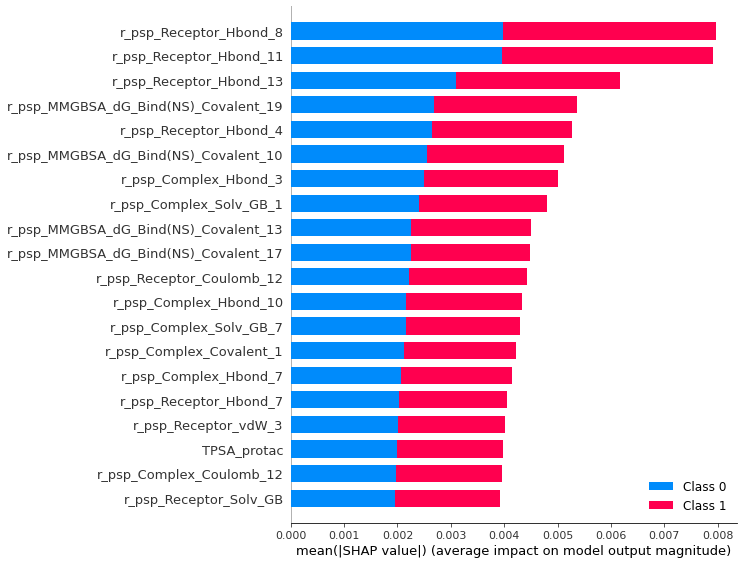

In [536]:
shap.summary_plot(shap_values, features=X_test_enc)

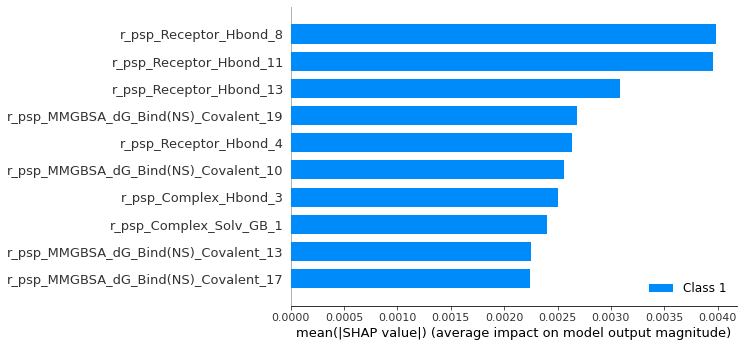

In [537]:
shap.summary_plot(shap_values, features=X_test_enc, class_inds=[1], max_display=10)

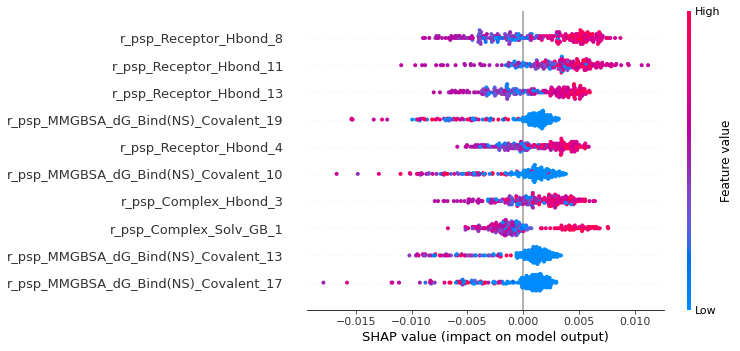

In [538]:
shap.summary_plot(shap_values[1], features=X_test_enc, max_display=10)

In [763]:
score=trained_hard.score(X_test, y_test)

In [764]:
score

0.8765432098765432

In [755]:
trained

VotingClassifier(estimators=[('logistic regression',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('standardscaler',
                                                                StandardScaler())])),
                                              ('logisticregression',
                                               LogisticRegression(C=0.06868491192268852,
                                                                  penalty='l1',
                                                                  solver='liblinear'))])),
                             ('random forest',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('standardscaler',
                                                                StandardScaler())])),
                                              ('randomforestcla...
                                              ('lg

In [756]:
print(y_test.shape)
print(y_test.value_counts())

(243,)
1    169
0     74
Name: flag, dtype: int64


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


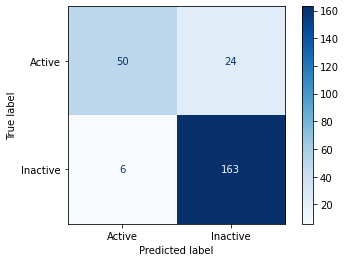

In [759]:
plot_confusion_matrix(
    trained_hard,
    X_test,
    y_test,
    display_labels=["Inactive", "Active"],
    values_format="d",
    cmap=plt.cm.Blues,
);

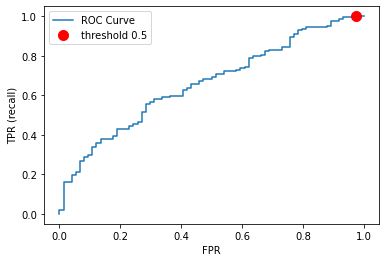

In [758]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, trained_hard.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");